In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv(r"dmt_reports.csv")
df.head()

,title,substance,age,weight,gender,report_text
0,First Experience of DMT,DMT,Age at time of experience: 27,NaN,Female,DOSE:T+ 0:000.5 hitsoralLSDT+ 0:453 hitssmoked...
1,Welcome to the Cube World,DMT,Age at time of experience: 18,80 kg,Not Specified,DOSE:1 hitsmokedDMT(powder / crystals)BODY WEI...
2,At the Threshold of Unimaginable Bliss,DMT,Age at time of experience: 22,NaN,Female,DOSE:repeatedsmokedCannabisrepeatedoralAlcohol...
3,What Is Time?,DMT,Age at time of experience: Not Given,230 lb,Male,DOSE:2 hitssmokedDMT(freebase)repeatedsmokedTo...
4,"Carrier Wave World of Forms, Beings of Light",DMT,Age at time of experience: 21,145 lb,Male,DOSE:34 - 40 mgvaporizedDMT(powder / crystals)...


In [2]:
import re
import contractions

def clean_psychedelic_report(text):
    """Initial structure cleanup: remove BODY WEIGHT... and trailing metadata"""
    if pd.isna(text):
        return ""

    text = text.replace('\xa0', ' ').replace('\n', ' ').strip()

    # Remove everything before BODY WEIGHT
    text = re.sub(r"^.*?BODY WEIGHT:\s*\d+\s*\w+\s*", "", text)

    # Remove everything after Exp Year
    end_match = re.search(r"Exp Year: \d{4}ExpID:", text)
    if end_match:
        text = text[:end_match.start()]

    return re.sub(r'\s{2,}', ' ', text).strip()

def remove_duplicates(text):
    """Remove repeated sentences"""
    sentences = text.split('. ')
    seen = set()
    unique_sentences = []
    for s in sentences:
        s_clean = s.strip()
        if s_clean and s_clean not in seen:
            seen.add(s_clean)
            unique_sentences.append(s_clean)
    return '. '.join(unique_sentences)

def final_nlp_clean(text):
    """Final normalization and cleaning for NLP"""
    if pd.isna(text):
        return ""

    # Contractions
    text = contractions.fix(text)

    # Remove parentheticals
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'\[[^\]]*\]', '', text)
    
    # Replace em/en dash, ellipsis, and double hyphen with comma
    text = text.replace('—', ',').replace('–', ',').replace('…', ',').replace('--', ',')

    # Standardize repeated punctuation
    text = re.sub(r'\.{2,}', '.', text)
    text = re.sub(r'!{2,}', '!', text)
    text = re.sub(r'\?{2,}', '?', text)

    # Add spacing after punctuation
    text = re.sub(r'(?<=[.!?])(?=\S)', r' ', text)

    # Separate camelCase
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

    # Collapse spaces and lowercase
    text = re.sub(r'\s{2,}', ' ', text).lower()

    return text.strip()

In [3]:
df['report_text'] = df['report_text'].apply(clean_psychedelic_report)
df['report_text'] = df['report_text'].apply(remove_duplicates)
df['report_text'] = df['report_text'].apply(final_nlp_clean)

In [4]:
def extract_age(text):
    """Extract age or return 'Not Given'."""
    if pd.isna(text):
        return "Not Given"
    match = re.search(r'Age at time of experience:\s*(\d+|Not Given)', text, re.IGNORECASE)
    return match.group(1) if match else "Not Given"

def extract_weight(text):
    """Extract weight in kg from lb, kg, or stone."""
    if pd.isna(text):
        return np.nan
    match = re.search(r'(\d+)\s*(lb|kg|st)', text.lower())
    if match:
        val, unit = int(match.group(1)), match.group(2)
        if unit == 'kg':
            return val
        elif unit == 'lb':
            return round(val * 0.453592)  # convert lb to kg
        elif unit == 'st':
            return round(val * 6.35029)   # convert stone to kg
    return np.nan

# Apply to columns
df['age'] = df['age'].apply(extract_age)
df['weight'] = df['weight'].apply(extract_weight)

In [5]:
df.tail()

,title,substance,age,weight,gender,report_text
1663,Crystal Creations,DMT,Not Given,66.0,Male,much to say. so much to say and yet no words f...
1664,Galactic Movements,DMT,Not Given,73.0,Male,has been a troublesome substance for me. it ca...
1665,Orange Gave Way to Utter Darkness,DMT,20,79.0,Male,started the night by going out to eat with my ...
1666,Visiting Hyperspace - Light Journey,DMT,35,91.0,Male,is probably the most mysterious drug known to ...
1667,Inhabitants of Another Dimension,DMT,18,86.0,Male,the middle of the woods in my area is a point ...


In [6]:
df['report_text'][5]

'. this experience of which i am about to tell you is my second encounter with dmt, which proved to be very different and much more powerful than the first trip, seeing as how my first trip was only a 30mg dose. i am a mildly experienced psychedelic user with several acid and shroom trips, i am also an avid pot smoker. we came across the dmt from a friend of a friend who makes it himself-being quite a science buff. on my first trip i indulged in the lovely tunes of ratatat’s mumtaz khan and several other songs from lp3, but for this trip i was going harder: oblivian by mastodon then mellowing things out with montanita by ratatat. with the pipe fully loaded with 50mg of pure white dmt and a bit of bud to mask the taste i began to indulge. after four hits i had pipe down~*~*~*i closed my eyes and blasted off into a crazy dancing vibalicious wormhole of insane color and emotion, i grooved for several minutes to the song . somehow i felt i was able to take another hit after five minutes or

In [7]:
def fix_common_mojibake(text):
    if not isinstance(text, str):
        return text

    replacements = {
        'â€™': "'",
        'â€œ': '"',
        'â€': '"',
        'â€“': '-', 
        'â€”': '-', 
        'â€¦': '...', 
        'Ã©': 'é',
        'Ã¨': 'è',
        'Ã¢': 'â',
        'Ãª': 'ê',
        'Ã´': 'ô',
        'Ã': 'à',
        'Â': '',  # sometimes appears before currency symbols
    }

    for wrong, right in replacements.items():
        text = text.replace(wrong, right)

    return text

df['report_text'] = df['report_text'].apply(fix_common_mojibake)

In [8]:
import re

def fix_leading_contractions_lower(text):
    if pd.isna(text):
        return ""

    # Beginning of text
    text = re.sub(r"^['‘’]m\b", "i am", text)
    text = re.sub(r"^['‘’]ve\b", "i have", text)
    text = re.sub(r"^['‘’]d\b", "i would", text)
    text = re.sub(r"^['‘’]ll\b", "i will", text)

    return text

df['report_text'] = df['report_text'].apply(fix_leading_contractions_lower)

In [9]:
# Define a word count function
def count_words(text):
    if pd.isna(text):
        return 0
    return len(str(text).split())

# Apply word count to each report
df['word_count'] = df['report_text'].apply(count_words)

In [10]:
# Count reports <500 and >2500 words
less_than_800 = (df['word_count'] < 500).sum()
greater_than_2000 = (df['word_count'] > 2500).sum()

print(f"Reports with fewer than 500 words: {less_than_800}")
print(f"Reports with more than 2500 words: {greater_than_2000}")

Reports with fewer than 500 words: 482
Reports with more than 2500 words: 55


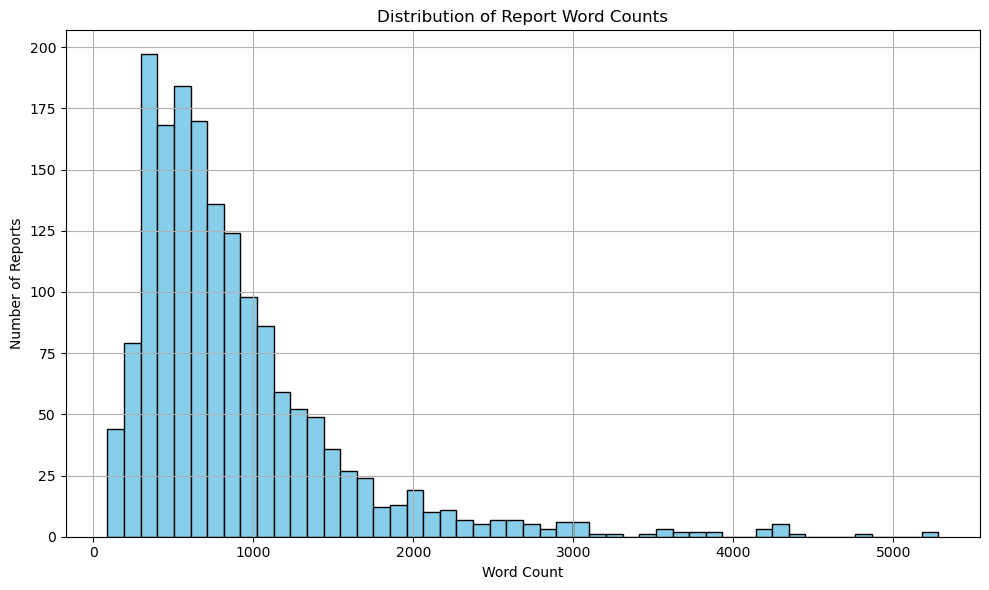

In [11]:
import matplotlib.pyplot as plt

# Plot histogram of word counts
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Report Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Number of Reports')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
df.shape

(1668, 7)

In [13]:
# Step 1: Filter reports between 500 and 2500 words
filtered_df = df[(df['word_count'] > 500) & (df['word_count'] < 2500)]

# Step 2: Randomly sample 800 reports from the filtered DataFrame
sampled_df = filtered_df.sample(n=800, random_state=42)  # random_state ensures reproducibility

# Step 3: Save to CSV
sampled_df.to_csv("dmt_800_reports.csv", index=False)

print(f"Filtered {len(filtered_df)} reports, saved 800 to 'dmt_800_reports.csv'")

Filtered 1127 reports, saved 800 to 'dmt_800_reports.csv'
